# Using samplers

Once a multimodal variational encoder is trained, new samples can be generated by sampling a latent code from the prior and then decoding it using the trained decoder distributions. 
However, joint generation of new samples can be improved by *a posteriori* fitting a distribution on the training latent codes and using that distribution to sample new latent variables closer to the ones seen in training. 
That strategy can be used to generate more realistic images. 

In MultiVae, three samplers are available in `multivae.samplers`
- A Gaussian Mixture Model (GMM)
- A Masked Autoregressive Flow (MAF) distribution.
- A Inverse Autoregressive Flow (IAF) distribution.

All implement parametric distributions that can be fit on the training latent codes of a trained model. 

In this notebook we provide examples on how they can be used. 
We load a trained model from HuggingFace Hub as an example model. 

If you don't have HuggingFace installed, run:
````bash
$ pip install huggingface_hub
````
to install it.


In [2]:
from multivae.models import AutoModel

model = AutoModel.load_from_hf_hub('asenella/reproducing_mvtcae_seed_0', allow_pickle=True)

No environment.json file found. If you have an error while pickling architectures, check that the python version used for saving is the same than the one you use for reloading the model.
Successfully downloaded encoders architecture.
Successfully downloaded decoders architecture.
Successfully downloaded MVTCAE model!


# Gaussian Mixture Sampler

First we will fit a Gaussian Mixture Model on the latent space of this multimodal VAE. 
We define the number of mixture components to be equal to 10 in this example. 

In [4]:
from multivae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

config = GaussianMixtureSamplerConfig(
    n_components=10 # number of components to use in the mixture
)

gmm_sampler = GaussianMixtureSampler(model=model,
                                 sampler_config=config)


We load the training multimodal dataset that we will use to compute latent codes and fit the GMM model. 

In [4]:
# load training set
from multivae.data.datasets.mmnist import MMNISTDataset

DATA_PATH = '/home/asenella/data' # Set your datapath
dataset = MMNISTDataset(data_path=DATA_PATH, 
                        split='train',
                        download=True
                        )



In [ ]:
# Fit the sampler (this might take a while)
gmm_sampler.fit(dataset)

You can now use this GMM model to sample relevant latent codes in the latent space of the model.

In [10]:
# you can now use that sampler to sample new latent codes, and new images

samples = gmm_sampler.sample(n_samples=3) 
images = model.decode(samples) # Decode the images. 

# Print the images shape
import matplotlib.pyplot as plt
for i,m in enumerate(images.keys()):
    print(images[m].shape)

torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])
torch.Size([3, 3, 28, 28])


You can also use that trained sampler in the evaluation modules. The sampler can be passed on as argument for the Visualization or Coherence Modules. 

Sampling from the prior:


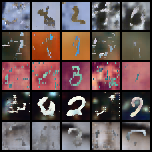

Sampling from the GMM model:


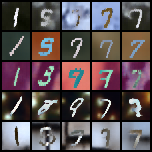

In [14]:
# For instance to visualize joint generation with the Visualization module

from multivae.metrics import Visualization, VisualizationConfig

print('Sampling from the prior:')

vis_module = Visualization(model,
                           dataset,
                           output='./metrics')

display(vis_module.unconditional_samples())

print('Sampling from the GMM model:')
vis_module = Visualization(model,
                           dataset,
                           output='./metrics',
                           sampler=gmm_sampler # Pass the trained sampler here. 
                           )

display(vis_module.unconditional_samples())

We see that the unconditional samples generated from the prior are less realistic than the ones sampled from the GMM. 

You can also provide the sampler to the Coherences or the FIDs evaluator to compute metrics on joint generation when using that prior.

We provide here an example using the Coherences.

To compute coherences, you need to load the PolyMNIST classifiers that were downloaded alongside the PolyMNIST dataset in `DATA_PATH`/clf.

Below, we define the architectures of the classifiers and load the state_dicts. 

In [10]:
import torch
from torch import nn
import os

#### Define the classifiers architectures

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class ClfImg(nn.Module):
    """
    MNIST image-to-digit classifier. Roughly based on the encoder from:
    https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb
    """

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(  # input shape (3, 28, 28)
            nn.Conv2d(3, 10, kernel_size=4, stride=2, padding=1),  # -> (10, 14, 14)
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=4, stride=2, padding=1),  # -> (20, 7, 7)
            nn.Dropout2d(0.5),
            nn.ReLU(),
            Flatten(),  # -> (980)
            nn.Linear(980, 128),  # -> (128)
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 10),  # -> (10)
        )

    def forward(self, x):
        h = self.encoder(x)
        # return F.log_softmax(h, dim=-1)
        return h


def load_mmnist_classifiers(data_path="your_data_path", device="cuda"):
    '''
    Function to load the classifiers state_dict.
    '''
    clfs = {}
    for i in range(5):
        fp = os.path.join(data_path,"pretrained_img_to_digit_clf_m" + str(i))
        model_clf = ClfImg()
        
        if os.path.exists(fp):
            model_clf.load_state_dict(torch.load(fp, map_location=torch.device(device)))
        else :
            print('Careful, untrained classifiers are used!')
            
        model_clf = model_clf.to(device)
        clfs["m%d" % i] = model_clf
    for m, clf in clfs.items():
        if clf is None:
            raise ValueError("Classifier is 'None' for modality %s" % str(i))
    return clfs



In [11]:
clfs = load_mmnist_classifiers(DATA_PATH + '/clf', device = 'cpu') # give the path to your classifiers here.
# is a dictionary with one network per modality

Then, when we define the CoherenceEvaluator module, we make sure to provide the GMM sampler to use for joint coherence. 

In [17]:
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

coherences_config = CoherenceEvaluatorConfig(batch_size=128,
                                             nb_samples_for_joint=100,
                                            #  wandb_path='your_wand_path'
                                             )

coherences_module = CoherenceEvaluator(model=model, 
                                       classifiers=clfs,
                                       output='./metrics',
                                       test_dataset=dataset,
                                       sampler=gmm_sampler # give the trained sampler as input here!
                                       )

coherences_module.joint_coherence()
coherences_module.finish()

Joint coherence with sampler GaussianMixtureSampler: 0.6204000115394592


You can compare this result with the joint coherence when sampling from the prior. 

In [20]:
coherences_module_without_sampler = CoherenceEvaluator(model=model, 
                                       classifiers=clfs,
                                       output='./metrics',
                                       test_dataset=dataset
                                       )

coherences_module_without_sampler.joint_coherence()
coherences_module_without_sampler.finish()

Joint coherence with sampler prior: 0.005200000014156103


# MAF sampler 

Below, we demonstrate how to fit and use a MAF sampler in MultiVae. It is very similar to the GMM sampler. 

In [5]:
from multivae.samplers import MAFSampler, MAFSamplerConfig

# Define architecture for the flows. 
maf_config = MAFSamplerConfig(
    n_made_blocks=2,
    n_hidden_in_made=3,
    hidden_size=64
)

# Define the MAF sampler
maf_sampler = MAFSampler(model, sampler_config=maf_config)


In [ ]:

# Fit the sampler
maf_sampler.fit(train_data=dataset,
                eval_data=None,
                training_config=None) # The fit function uses a Pythae's Trainer to fit the flow model. 
                                    # You can pass a BaseTrainerConfig instance to specify the number of epochs, the learning rate ...

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Created dummy_output_dir/MAF_training_2025-02-24_11-26-01. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Training of epoch 1/100: 100%|██████████| 938/938 [00:03<00:00, 242.44batch/s]
--------------------------------------------------------------------------
Train loss: 45950.009
--------------------------------------------------------------------------
Training of epoch 2/100: 100%|██████████| 938/938 [00:03<00:00, 245.46batch/s]
-----------

For the MAF and IAF sampler, the trained sampler can be saved and reloaded:

In [ ]:
maf_sampler.save('./trained_maf_sampler')

Later on, you can redefine a new sampler (with the same arguments as the first one) and reload the trained weights for the flows:

In [6]:
trained_sampler = MAFSampler(model, maf_config)

trained_sampler.load_flows_from_folder('./trained_maf_sampler')

Like the GGM sampler, that sampler can be used to sample in the latent space and with the Evaluators modules to compute metrics.

In [7]:
# Let's sample from the MAF distribution
trained_sampler.sample(n=5)

ModelOutput([('z',
              tensor([[ 4.3084e-01, -1.2771e+00,  1.0439e+00, -3.3159e-02,  5.9921e-03,
                        1.3451e+00,  1.9132e+00, -5.6658e-02, -1.9737e+00,  1.9766e-01,
                        8.5533e-01,  6.0897e-01,  2.3189e+00, -5.9841e-01, -8.4162e-01,
                        6.4756e-01,  3.8201e-01,  1.5077e+00,  1.4646e+00, -1.3272e+00,
                       -7.9372e-01, -3.7068e-01,  3.8428e-01, -7.3923e-01, -9.6031e-01,
                        4.1648e-01, -2.1174e+00,  2.4830e-01, -7.3368e-01,  3.6846e-01,
                        1.2346e+00,  3.6108e-01, -3.8055e-01, -7.1099e-01, -2.3521e+00,
                        6.3818e-01, -2.4699e-01, -3.2461e-01, -6.3442e-01,  7.2660e-01,
                       -1.1798e+00, -1.4323e+00,  2.5585e-01,  2.1891e+00, -8.0457e-01,
                       -7.3656e-01,  6.3565e-01, -1.9903e+00,  4.3314e-01,  1.1014e+00,
                       -1.3346e+00,  7.5482e-01, -7.4145e-01,  8.3710e-01,  7.6100e-01,
             

We can use this sampler to compute joint generation coherence:

In [12]:
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

coherences_config = CoherenceEvaluatorConfig(batch_size=128,
                                             nb_samples_for_joint=100,
                                            #  wandb_path='your_wand_path'
                                             )

coherences_module = CoherenceEvaluator(model=model, 
                                       classifiers=clfs,
                                       output='./metrics',
                                       test_dataset=dataset,
                                       sampler=trained_sampler # give the trained MAF sampler as input here!
                                       )

coherences_module.joint_coherence()
coherences_module.finish()

Joint coherence with sampler MAFsampler: 0.18709999322891235
